# Experimento: Clasificación de asuntos mediante embeddings y similitud coseno

## Descripción general

En esta notebook se evalúa un enfoque de clasificación de asuntos administrativos
basado en representaciones vectoriales semánticas (*embeddings*) y medidas de
similitud, específicamente la similitud coseno.

Este experimento se ubica conceptualmente entre los métodos clásicos de
Machine Learning (por ejemplo, TF-IDF) y los enfoques basados en modelos de
lenguaje generativos (LLM).

---

## Objetivo del experimento

- Evaluar el uso de embeddings de texto para capturar similitud semántica
  entre asuntos administrativos y descripciones de áreas.
- Analizar la efectividad de la similitud coseno como criterio de asignación
  de área.
- Explorar una alternativa más robusta sin necesidad de entrenamiento supervisado.

---

## Enfoque metodológico

- Se utiliza la API de OpenAI para generar embeddings de texto
  (modelo de embeddings de tamaño reducido).
- Cada asunto se transforma en un vector numérico de alta dimensión.
- Las descripciones de las áreas administrativas también se embeben en el mismo espacio vectorial.
- La clasificación se realiza calculando la similitud coseno entre el asunto
  y cada área, asignando aquella con mayor similitud.

---

## Resultados y observaciones

El enfoque basado en embeddings presenta:

- Ventajas:
  - Captura similitud semántica más allá de coincidencias léxicas.
  - No requiere entrenamiento supervisado.

- Limitaciones:
  - Dependencia del modelo de embeddings.
  - Sensibilidad a la calidad de las descripciones de las áreas.
  - Menor flexibilidad que un LLM para resolver ambigüedades complejas.

---

## Rol dentro del proyecto

Este experimento permitió validar el valor de las representaciones semánticas
para el problema de clasificación y sirvió como paso intermedio hacia la adopción
de un enfoque basado en modelos de lenguaje completos.

Los aprendizajes obtenidos influyeron en el diseño del prompt y en la decisión
final de utilizar un LLM como solución productiva.


# Experimento con OpenAI Embeddings 🎯

##Idea general del experimento

1- Generar embeddings para:

* cada asunto del dataset

* cada área (a partir de su descripción refinada)

2- Para cada asunto:

* calcular similitud coseno contra todas las áreas

* elegir el área más cercana (top-1)

* opcional: top-3

3- Evaluar:

* accuracy, F1

* matriz de confusión

4- Guardar resultados y métricas en Drive como nuevo experimento.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [ ]:
# 1) Cargar tus datos (id, asunto, cuerpo, area_destino)
df = pd.read_csv("/content/drive/MyDrive/Diplo-2025/Proyecto/24 11 Proyecto/Dataset_24-11.csv")  # ← arma este CSV

In [ ]:
df

,Fecha de creación,Asunto,AREA OBJETIVO
0,8/9/2025,ADJUNTAR DOCUMENTACIÓN SOLICITADA,MESA DE ENTRADAS
1,8/9/2025,CAMBIO DE TITULARIDAD PARA ADJUDICATARIOS,REGULARIZACION DOMINIAL
2,8/9/2025,CANCELACION DE HIPOTECA,GESTION FINANCIERA
3,8/9/2025,COMBUSTIBLE PARA VEHICULOS OFICIALES - PETROLE...,ADMINISTRACION
4,8/9/2025,CUPON DE PAGO - CAMBIO DE TITULARIDAD,REGULARIZACION DOMINIAL/GESTION FINANCIERA
...,...,...,...
751,31/07/2025,TURNO ESCRITURA,ESCRITURACIONES
752,31/07/2025,ESCRITURA DE MI TERRENO SEGUNDO TESTIMONIO,ESCRITURACIONES
753,31/07/2025,PONERME AL DIA CON MI DEUDA,GESTION FINANCIERA
754,31/07/2025,DIRECCION DE VIVIENDA - SOLICITA INSCRIPCION D...,REGULARIZACION DOMINIAL


In [ ]:
df = df.rename(columns={
    "Asunto": "asunto",
    "AREA OBJETIVO": "area_objetivo"
})

df["area_objetivo"] = df["area_objetivo"].astype(str).str.strip()
df["asunto"] = df["asunto"].astype(str).str.strip()


In [ ]:
df["asunto"] = df["asunto"].str.lower().str.normalize('NFKD').str.encode('ascii','ignore').str.decode('utf-8')

In [ ]:
df.describe(include='O')

,Fecha de creación,asunto,area_objetivo
count,756,756,756
unique,47,543,10
top,9/9/2025,"solicitud de cuotas, cancelacion y libre de de...",REGULARIZACION DOMINIAL
freq,38,58,253


In [ ]:
df['area_objetivo'] = df['area_objetivo'].str.strip()
print("Value counts after stripping whitespace:")
df['area_objetivo'].value_counts()

Value counts after stripping whitespace:


,count
area_objetivo,
REGULARIZACION DOMINIAL,253
GESTION FINANCIERA,211
ESCRITURACIONES,150
MESA DE ENTRADAS,56
ADMINISTRACION,54
REGULARIZACION DOMINIAL/GESTION FINANCIERA,12
JURIDICO,8
REGULARIZACION DOMINIAL/ESCRITURACIONES,5
TECNICA,4


In [ ]:
df['area_objetivo'] = df['area_objetivo'].replace('GESTION FINANCIERA/ESCRITURACIONES', 'GESTION FINANCIERA')
df['area_objetivo'] = df['area_objetivo'].replace(['REGULARIZACION DOMINIAL/GESTION FINANCIERA', 'REGULARIZACION DOMINIAL/ESCRITURACIONES'], 'REGULARIZACION DOMINIAL')
df['area_objetivo'].value_counts()

,count
area_objetivo,
REGULARIZACION DOMINIAL,270
GESTION FINANCIERA,214
ESCRITURACIONES,150
MESA DE ENTRADAS,56
ADMINISTRACION,54
JURIDICO,8
TECNICA,4


In [ ]:
conteo_area = df["area_objetivo"].value_counts()
porcentaje_area = df["area_objetivo"].value_counts(normalize=True) * 100

dist_areas = pd.DataFrame({
    "registros": conteo_area,
    "porcentaje": porcentaje_area.round(2)
})

dist_areas


,registros,porcentaje
area_objetivo,,
REGULARIZACION DOMINIAL,270,35.71
GESTION FINANCIERA,214,28.31
ESCRITURACIONES,150,19.84
MESA DE ENTRADAS,56,7.41
ADMINISTRACION,54,7.14
JURIDICO,8,1.06
TECNICA,4,0.53


In [ ]:
# 1) Duplicados 100% idénticos (asunto + área + palabra)
df["es_dup_exacto"] = df.duplicated(
    subset=["asunto", "area_objetivo"],
    keep=False  # marca todos los que estén en grupos duplicados
)

# 2) Duplicados por asunto dentro de la misma área
df["es_dup_asunto_en_area"] = df.duplicated(
    subset=["asunto", "area_objetivo"],
    keep=False
)

In [ ]:
resumen_area = df.groupby("area_objetivo").agg(
    total_registros=("asunto", "size"),
    asuntos_unicos=("asunto", "nunique"),
    registros_en_grupos_dup_exacto=("es_dup_exacto", "sum"),
    registros_en_grupos_dup_asunto_area=("es_dup_asunto_en_area", "sum")
)

resumen_area["porc_reg_en_dup_exacto"] = (
    resumen_area["registros_en_grupos_dup_exacto"] / resumen_area["total_registros"] * 100
).round(2)

resumen_area["porc_reg_en_dup_asunto_area"] = (
    resumen_area["registros_en_grupos_dup_asunto_area"] / resumen_area["total_registros"] * 100
).round(2)

resumen_area.sort_values("total_registros", ascending=False)


,total_registros,asuntos_unicos,registros_en_grupos_dup_exacto,registros_en_grupos_dup_asunto_area,porc_reg_en_dup_exacto,porc_reg_en_dup_asunto_area
area_objetivo,,,,,,
REGULARIZACION DOMINIAL,270,211,77,77,28.52,28.52
GESTION FINANCIERA,214,152,67,67,31.31,31.31
ESCRITURACIONES,150,75,78,78,52.00,52.00
MESA DE ENTRADAS,56,51,9,9,16.07,16.07
ADMINISTRACION,54,42,19,19,35.19,35.19
JURIDICO,8,8,0,0,0.00,0.00
TECNICA,4,4,0,0,0.00,0.00


Esto ya te responde cosas como:

“En el área X, el 60% de los registros pertenecen a asuntos repetidos”

“El área Y tiene pocos asuntos, pero muy repetidos”

In [ ]:
print(f"Number of duplicate rows in df: {df.duplicated(subset=['asunto']).sum()}")

Number of duplicate rows in df: 213


In [ ]:
print(f"Number of duplicate rows in df_filtered: {df.duplicated(subset=['asunto']).sum()}")
if df.duplicated().sum() > 0:
    print("Duplicate rows:")
    print(df[df.duplicated(subset=['asunto'],keep=False)].sort_values(by='asunto'))
else:
    print("No duplicate rows found.")

Number of duplicate rows in df_filtered: 213
Duplicate rows:
    Fecha de creación                                             asunto  \
732        29/07/2025                         actualizar cedulon vencido   
456        10/07/2025                         actualizar cedulon vencido   
719        28/07/2025  adelantamiento de cuotas de planes provinciale...   
407        06/07/2025  adelantamiento de cuotas de planes provinciale...   
118         12/9/2025  adelantamiento de cuotas de planes provinciale...   
..                ...                                                ...   
243         19/9/2025  suministro de gas natural - distribuidora de g...   
481        11/07/2025  suministro de gas natural - distribuidora de g...   
620        21/07/2025                                           vivienda   
244         19/9/2025                                           vivienda   
68           9/9/2025                                           vivienda   

          area_objetivo  e

In [ ]:
df.shape

(756, 5)

In [ ]:
df = df.drop_duplicates(subset=['asunto'])
df.shape

(543, 5)

In [ ]:
df['area_objetivo_codificada'], _ = pd.factorize(df['area_objetivo'])

/tmp/ipython-input-3365389077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['area_objetivo_codificada'], _ = pd.factorize(df['area_objetivo'])


In [ ]:
df

,Fecha de creación,asunto,area_objetivo,es_dup_exacto,es_dup_asunto_en_area,area_objetivo_codificada
0,8/9/2025,adjuntar documentacion solicitada,MESA DE ENTRADAS,True,True,0
1,8/9/2025,cambio de titularidad para adjudicatarios,REGULARIZACION DOMINIAL,True,True,1
2,8/9/2025,cancelacion de hipoteca,GESTION FINANCIERA,True,True,2
3,8/9/2025,combustible para vehiculos oficiales - petrole...,ADMINISTRACION,False,False,3
4,8/9/2025,cupon de pago - cambio de titularidad,REGULARIZACION DOMINIAL,False,False,1
...,...,...,...,...,...,...
751,31/07/2025,turno escritura,ESCRITURACIONES,False,False,4
752,31/07/2025,escritura de mi terreno segundo testimonio,ESCRITURACIONES,False,False,4
753,31/07/2025,ponerme al dia con mi deuda,GESTION FINANCIERA,False,False,2
754,31/07/2025,direccion de vivienda - solicita inscripcion d...,REGULARIZACION DOMINIAL,False,False,1


In [ ]:
area_mapping = dict(zip(df['area_objetivo'], df['area_objetivo_codificada']))
print("Mapping of 'AREA OBJETIVO' to Numerical Codes:")
print(area_mapping)

Mapping of 'AREA OBJETIVO' to Numerical Codes:
{'MESA DE ENTRADAS': 0, 'REGULARIZACION DOMINIAL': 1, 'GESTION FINANCIERA': 2, 'ADMINISTRACION': 3, 'ESCRITURACIONES': 4, 'JURIDICO': 5, 'TECNICA': 6}


Vamos a Mejorar la descripción de cada area. Para dicho proceso vamos a tener en cuenta:

* Evitar frases genéricas: “se encarga de…” NO aporta semántica.

* Usar sustantivos + verbos de acción específicos.

* Incluir palabras clave como parte integrada del texto, no como lista aislada.

* Meter ejemplos concretos (mejoran mucho los embeddings).

* Evitar términos de otras áreas para no sesgar.

* Dejar fuera palabras ultra frecuentes como “trámite”, “nota”, “solicitud”.

In [ ]:
### Versión anterior
# # Diccionario: AREA -> DESCRIPCION (puede ser más larga si querés)
# area_descripciones = {
#     "MESA DE ENTRADAS": """RECEPCION DE TRAMITES, ARCHIVO DE TRAMITES, ATENCION INICIAL, INGRESO Y DERIVACION DE NOTAS, REGISTRO Y CONTROL DE DOCUMENTACION""",
#     "ADMINISTRACION": """SE ENCARGA DE TODOS LOS PAGOS A PROVEEDORES, ABONAR LOS GASTOS EN BIENES Y SERVICIOS, RENDICIONES DE CUENTAS, CONTROL ADMINISTRATIVO, GESTION DE COMPROBANTES""",
#     "GESTION FINANCIERA": """COBROS DE CUOTAS, COMPENSACIONES, CANCELACIONES, LIBRES DE DEUDA,GESTION DE PAGOS DE BENEFICIARIOS, ESTADOS DE CUENTA""",
#     "TECNICA": """ARQUITECTOS QUE SE ENCARGAN DE LAS OBRAS, PROYECTOS, INSPECCIONES, PLANOS, CERTIFICACIONES TECNICAS, RELEVAMIENTOS""",
#     "REGULARIZACION DOMINIAL": """SE ENCARGA DE LAS ADJUDICACIONES, READJUDICACIONES, REFINANCIACIONES, CAMBIOS DE TITULARIDAD, REGULARIZACION DE SITUACIONES DOMINIALES""",
#     "JURIDICO": """ABOGADOS QUE SE ENCARGAN DE TODOS LOS TRAMITES LEGALES, DICTAMENES, CONTRATOS, RECLAMOS, SUMARIOS, ASESORAMIENTO LEGAL""",
#     "ESCRITURACIONES": """RESUELVEN TODOS LOS TRAMITES RELACIONADOS A LA ENTREGA DE ESCRITURAS A LOS BENEFICIARIOS, GESTION NOTARIAL, DOCUMENTACION ESCRITURARIA"""
# }

In [ ]:
area_descripciones = {
    "MESA DE ENTRADAS": """
        Mesa de Entradas gestiona el ingreso inicial de documentación,
        recibe notas y expedientes, registra la fecha de entrada,
        clasifica la información según tipo de trámite, realiza archivo
        y desarchivo, organiza anexos y deriva la documentación a las
        áreas correspondientes. Incluye la recepción física y digital
        de documentación, control de archivos, ordenamiento de expedientes
        y actualización del registro institucional.
    """,

    "ADMINISTRACION": """
        Administración gestiona pagos a proveedores, controla facturas
        y comprobantes, ejecuta rendiciones de gastos, administra presupuestos,
        tramita órdenes de pago, revisa liquidaciones, valida servicios
        contratados y realiza auditorías contables internas. Incluye tareas
        relacionadas con servicios como Aguas Cordobesas, EPEC, Telecom,
        Gas del Centro, honorarios profesionales, materiales, combustible,
        librería y auditorías del Tribunal de Cuentas.
    """,

    "GESTION FINANCIERA": """
        Gestión Financiera administra el cobro de cuotas a beneficiarios,
        emite cupones y cedulones de pago, gestiona cancelaciones,
        adelantamientos y compensaciones de cuotas, maneja débitos automáticos,
        medios de pago electrónicos, cálculo y actualización de deudas,
        emisión de certificados de libre deuda y estados de cuenta.
    """,

    "TECNICA": """
        El área Técnica realiza tareas vinculadas a obras y proyectos:
        revisión y visado de planos, inspecciones en obra, certificación
        de avances, relevamientos técnicos, valuación y depreciación de
        viviendas, informes técnicos de remodelación y construcción,
        coordinación con agrimensores y arquitectos y control de
        deterioros estructurales y documentación técnica.
    """,

    "REGULARIZACION DOMINIAL": """
        Regularización Dominial gestiona adjudicaciones y readjudicaciones,
        cambios de titularidad, refinanciaciones de deuda, planes de pago,
        regularización de cuotas, contratos, permutas, restituciones,
        situaciones de abandono o desocupación, acreditación de derecho,
        compra y venta de viviendas y actualización de documentación dominial.
        Incluye análisis dominial, evaluación de ocupación y control de documentación.
    """,

    "JURIDICO": """
        El área Jurídica interviene en trámites legales: elaboración de dictámenes,
        redacción y revisión de contratos, gestión de recursos administrativos,
        juicios, amparos, pronto despacho, cartas documento, articulación con
        juzgados y asesoramiento legal integral en situaciones conflictivas y
        en procesos de resolución de controversias.
    """,

    "ESCRITURACIONES": """
        Escrituraciones tramita la documentación notarial necesaria para entregar
        las escrituras a beneficiarios, gestiona firmas con escribanos, prepara
        documentación registral, coordina ventas con hipoteca, verifica requisitos
        legales para la escrituración y realiza seguimiento del proceso notarial
        hasta la inscripción definitiva en el registro correspondiente.
    """
}


In [ ]:
area_descripciones_df = pd.DataFrame.from_dict(area_descripciones, orient='index', columns=['descripcion'])
area_descripciones_df

,descripcion
MESA DE ENTRADAS,\n Mesa de Entradas gestiona el ingreso...
ADMINISTRACION,\n Administración gestiona pagos a prov...
GESTION FINANCIERA,\n Gestión Financiera administra el cob...
TECNICA,\n El área Técnica realiza tareas vincu...
REGULARIZACION DOMINIAL,\n Regularización Dominial gestiona adj...
JURIDICO,\n El área Jurídica interviene en trámi...
ESCRITURACIONES,\n Escrituraciones tramita la documenta...


# API OpenAI

In [ ]:
from google.colab import userdata

try:
    print("OK → userdata está disponible")
except:
    print("⚠️ userdata NO está disponible en este entorno")

OK → userdata está disponible


In [ ]:
from google.colab import userdata
openai_key = userdata.get("API_OpenAI")

print(openai_key[:6], "...")  # Nunca imprimas la key completa

sk-pro ...


In [ ]:
!pip install --upgrade openai

In [ ]:
import os
from openai import OpenAI

# Asegurate de tener la API Key en la variable de entorno
# En Colab por ejemplo:
# os.environ["OPENAI_API_KEY"] = "tu_clave"
os.environ["OPENAI_API_KEY"] = userdata.get("API_OpenAI")
client = OpenAI()

EMBEDDING_MODEL = "text-embedding-3-small"  # o "text-embedding-3-large"

In [ ]:
import numpy as np

_embedding_cache = {}

def get_embedding(text: str, model: str = EMBEDDING_MODEL):
    """
    Devuelve el embedding de un texto usando OpenAI, con cache simple.
    """
    text = text.strip()
    if text in _embedding_cache:
        return _embedding_cache[text]

    response = client.embeddings.create(
        model=model,
        input=text
    )
    vec = np.array(response.data[0].embedding, dtype=float)
    _embedding_cache[text] = vec
    return vec


Costo = X - 0.51

In [ ]:
area_ids = list(area_descripciones.keys())
area_texts = [area_descripciones[a] for a in area_ids]

area_vecs = {}

for area, desc in zip(area_ids, area_texts):
    v = get_embedding(desc)
    area_vecs[area] = v

# Chequeo rápido
for a, v in area_vecs.items():
    print(a, v.shape)


MESA DE ENTRADAS (1536,)
ADMINISTRACION (1536,)
GESTION FINANCIERA (1536,)
TECNICA (1536,)
REGULARIZACION DOMINIAL (1536,)
JURIDICO (1536,)
ESCRITURACIONES (1536,)


In [ ]:
df_exp = df.copy()

df_exp["asunto_texto_modelo"] = df_exp["asunto"].fillna("").astype(str)

asunto_embeddings = []

for txt in df_exp["asunto_texto_modelo"]:
    v = get_embedding(txt)
    asunto_embeddings.append(v)

df_exp["asunto_embedding_openai"] = asunto_embeddings


In [ ]:
def cos_sim(a, b):
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0.0 or nb == 0.0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))


def predecir_area_por_embedding(v_asunto, area_vecs, top_k=3):
    if v_asunto is None or np.linalg.norm(v_asunto) == 0.0:
        return [("Sin información suficiente", 0.0)]

    scores = []
    for area_id, v_area in area_vecs.items():
        score = cos_sim(v_asunto, v_area)
        scores.append((area_id, score))

    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:top_k]


In [ ]:
df_exp["topk_afinidad_openai"] = df_exp["asunto_embedding_openai"].apply(
    lambda v: predecir_area_por_embedding(v, area_vecs, top_k=3)
)

def extraer_top1(lista_scores):
    if not isinstance(lista_scores, (list, tuple)) or len(lista_scores) == 0:
        return None
    return lista_scores[0][0]

df_exp["area_pred_openai_top1"] = df_exp["topk_afinidad_openai"].apply(extraer_top1)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

reverse_mapping = {codigo: nombre for nombre, codigo in area_mapping.items()}
df_exp["area_objetivo_nombre"] = df_exp["area_objetivo_codificada"].map(reverse_mapping)

y_true = df_exp["area_objetivo_nombre"]
y_pred = df_exp["area_pred_openai_top1"]

print("Accuracy top-1 (OpenAI Embeddings):", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))


Accuracy top-1 (OpenAI Embeddings): 0.7440147329650092
                         precision    recall  f1-score   support

         ADMINISTRACION       0.55      0.55      0.55        42
        ESCRITURACIONES       0.71      0.96      0.82        75
     GESTION FINANCIERA       0.92      0.66      0.77       152
               JURIDICO       1.00      0.38      0.55         8
       MESA DE ENTRADAS       0.69      0.22      0.33        51
REGULARIZACION DOMINIAL       0.72      0.92      0.81       211
                TECNICA       0.33      0.25      0.29         4

               accuracy                           0.74       543
              macro avg       0.70      0.56      0.59       543
           weighted avg       0.76      0.74      0.72       543



In [ ]:
def acierta_en_topk(row, k=3):
    area_real = row["area_objetivo_nombre"]
    lista = row["topk_afinidad_openai"]
    if not isinstance(lista, (list, tuple)) or len(lista) == 0:
        return 0
    areas_topk = [a for a, _ in lista[:k]]
    return int(area_real in areas_topk)

df_exp["acierto_top3_openai"] = df_exp.apply(acierta_en_topk, axis=1, k=3)
print("Accuracy top-3 (OpenAI Embeddings):", df_exp["acierto_top3_openai"].mean())


Accuracy top-3 (OpenAI Embeddings): 0.9318600368324125


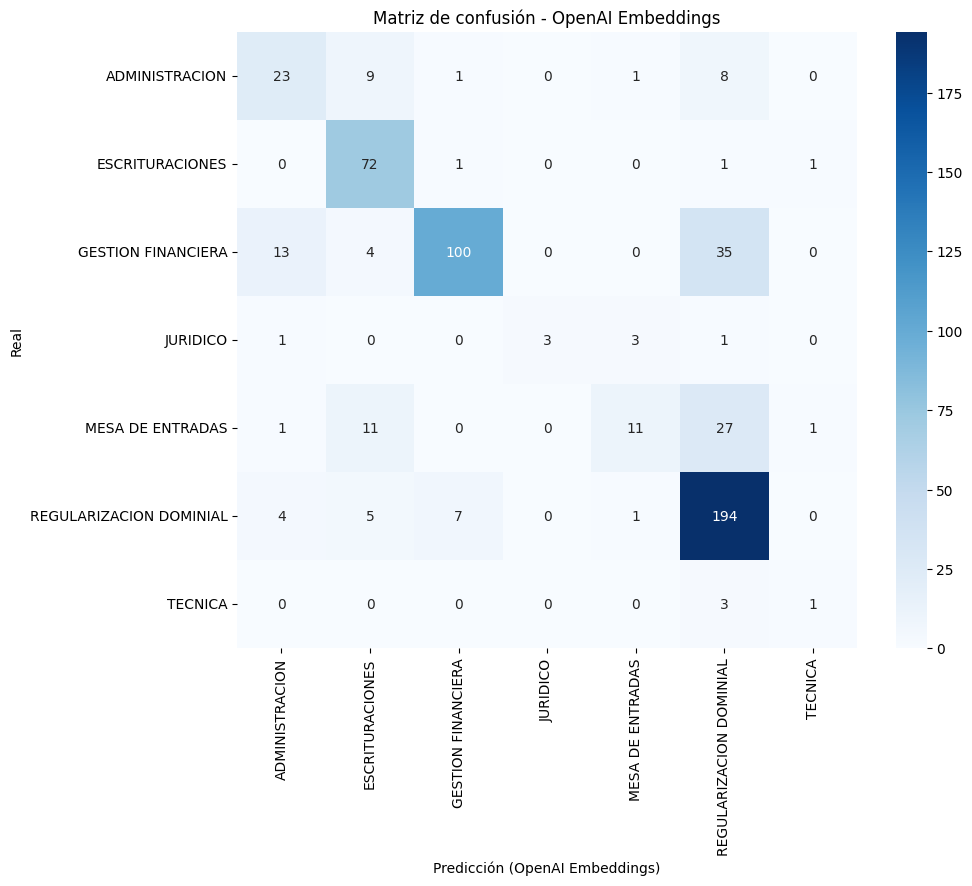

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = sorted(y_true.unique())
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción (OpenAI Embeddings)")
plt.ylabel("Real")
plt.title("Matriz de confusión - OpenAI Embeddings")
plt.show()


# Resultados Experimento

In [ ]:
df_exp

,Fecha de creación,asunto,area_objetivo,es_dup_exacto,es_dup_asunto_en_area,area_objetivo_codificada,asunto_texto_modelo,asunto_embedding_openai,topk_afinidad_openai,area_pred_openai_top1,area_objetivo_nombre,acierto_top3_openai
0,8/9/2025,adjuntar documentacion solicitada,MESA DE ENTRADAS,True,True,0,adjuntar documentacion solicitada,"[-0.01623709686100483, 0.03489800915122032, 0....","[(MESA DE ENTRADAS, 0.426078620259321), (ESCRI...",MESA DE ENTRADAS,MESA DE ENTRADAS,1
1,8/9/2025,cambio de titularidad para adjudicatarios,REGULARIZACION DOMINIAL,True,True,1,cambio de titularidad para adjudicatarios,"[0.0180131196975708, 0.016155971214175224, 0.0...","[(REGULARIZACION DOMINIAL, 0.5225263740247855)...",REGULARIZACION DOMINIAL,REGULARIZACION DOMINIAL,1
2,8/9/2025,cancelacion de hipoteca,GESTION FINANCIERA,True,True,2,cancelacion de hipoteca,"[0.003291469532996416, 0.035460397601127625, 0...","[(ESCRITURACIONES, 0.36464001039756855), (REGU...",ESCRITURACIONES,GESTION FINANCIERA,1
3,8/9/2025,combustible para vehiculos oficiales - petrole...,ADMINISTRACION,False,False,3,combustible para vehiculos oficiales - petrole...,"[0.0007744703907519579, -0.016362933441996574,...","[(ADMINISTRACION, 0.29281972230042635), (REGUL...",ADMINISTRACION,ADMINISTRACION,1
4,8/9/2025,cupon de pago - cambio de titularidad,REGULARIZACION DOMINIAL,False,False,1,cupon de pago - cambio de titularidad,"[0.037607599049806595, 0.002800463931635022, -...","[(REGULARIZACION DOMINIAL, 0.4506536823838211)...",REGULARIZACION DOMINIAL,REGULARIZACION DOMINIAL,1
...,...,...,...,...,...,...,...,...,...,...,...,...
751,31/07/2025,turno escritura,ESCRITURACIONES,False,False,4,turno escritura,"[0.025539766997098923, 0.03986964747309685, 0....","[(ESCRITURACIONES, 0.396494836393324), (MESA D...",ESCRITURACIONES,ESCRITURACIONES,1
752,31/07/2025,escritura de mi terreno segundo testimonio,ESCRITURACIONES,False,False,4,escritura de mi terreno segundo testimonio,"[0.05015017092227936, 0.04065125808119774, 0.0...","[(ESCRITURACIONES, 0.4317589512920069), (REGUL...",ESCRITURACIONES,ESCRITURACIONES,1
753,31/07/2025,ponerme al dia con mi deuda,GESTION FINANCIERA,False,False,2,ponerme al dia con mi deuda,"[0.017056971788406372, -0.02929583191871643, -...","[(GESTION FINANCIERA, 0.3738444589705579), (RE...",GESTION FINANCIERA,GESTION FINANCIERA,1
754,31/07/2025,direccion de vivienda - solicita inscripcion d...,REGULARIZACION DOMINIAL,False,False,1,direccion de vivienda - solicita inscripcion d...,"[0.05107082426548004, 0.030778944492340088, 0....","[(REGULARIZACION DOMINIAL, 0.5436963219487041)...",REGULARIZACION DOMINIAL,REGULARIZACION DOMINIAL,1


 MÉTRICAS GENERALES - OpenAI Embeddings

Accuracy top-1: 0.7440147329650092

Reporte de clasificación:

                         precision    recall  f1-score   support

         ADMINISTRACION       0.55      0.55      0.55        42
        ESCRITURACIONES       0.71      0.96      0.82        75
     GESTION FINANCIERA       0.92      0.66      0.77       152
               JURIDICO       1.00      0.38      0.55         8
       MESA DE ENTRADAS       0.69      0.22      0.33        51
REGULARIZACION DOMINIAL       0.72      0.92      0.81       211
                TECNICA       0.33      0.25      0.29         4

               accuracy                           0.74       543
              macro avg       0.70      0.56      0.59       543
           weighted avg       0.76      0.74      0.72       543


 MATRIZ DE CONFUSIÓN



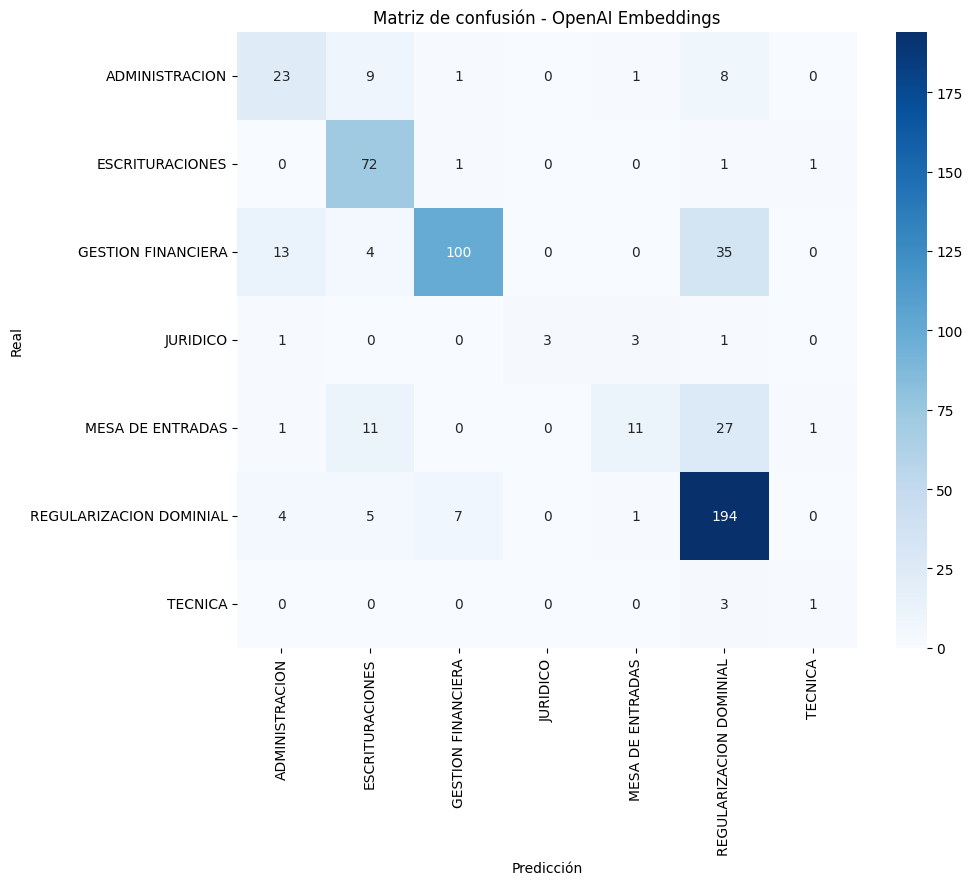

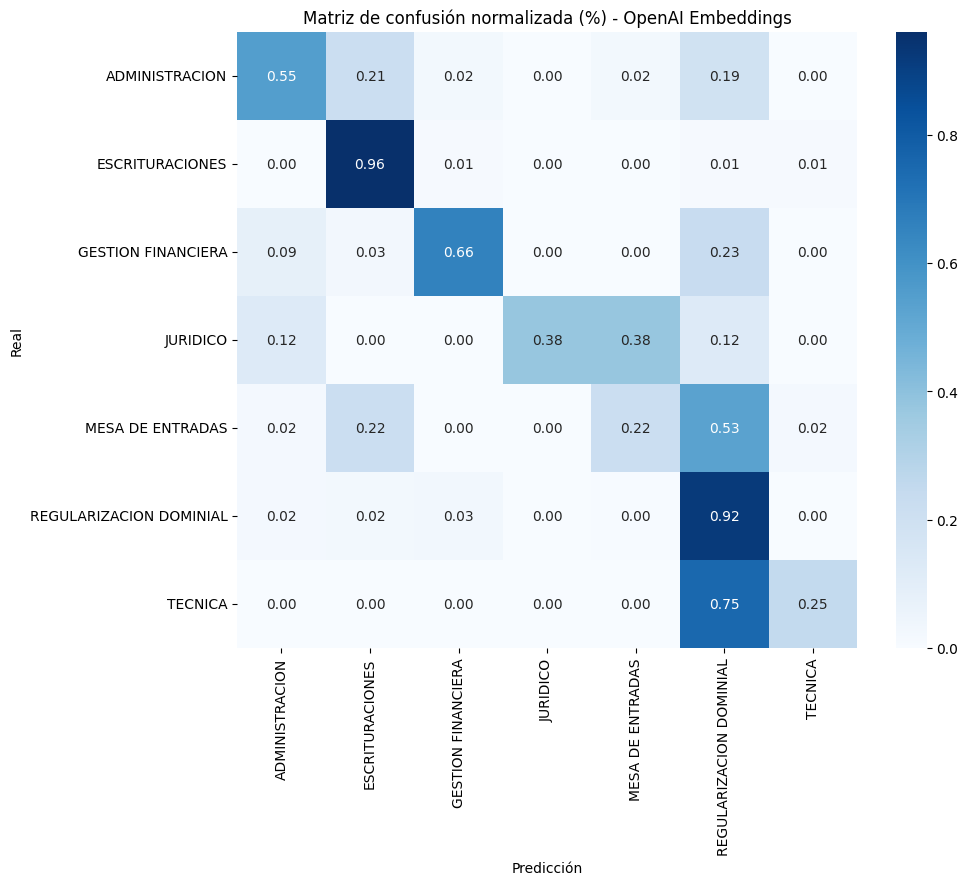


 TOP ERRORES (primeros 15)



,asunto,area_objetivo_nombre,area_pred_openai_top1
2,cancelacion de hipoteca,GESTION FINANCIERA,ESCRITURACIONES
13,solicito cancelacion de lote escriturado,GESTION FINANCIERA,ESCRITURACIONES
30,solicitud terreno,MESA DE ENTRADAS,ESCRITURACIONES
37,cumplimento notificacion en tramite sticker 1054818111525,MESA DE ENTRADAS,ESCRITURACIONES
40,honorarios servicios de escribania - auchterlonie maria milagros -,ADMINISTRACION,ESCRITURACIONES
41,honorarios servicios de escribania - monnier cristina -,ADMINISTRACION,ESCRITURACIONES
43,honorarios servicios de escribania - suarez paula natalia -,ADMINISTRACION,ESCRITURACIONES
51,solicito cancelcion de deuda vivienda sociales,GESTION FINANCIERA,REGULARIZACION DOMINIAL
68,vivienda,MESA DE ENTRADAS,REGULARIZACION DOMINIAL
73,propiedad vendida,MESA DE ENTRADAS,REGULARIZACION DOMINIAL



 ACCURACY POR ÁREA



/tmp/ipython-input-2852915225.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["area_pred_openai_top1"] == x["area_objetivo_nombre"]).mean())


,0
area_objetivo_nombre,
ESCRITURACIONES,0.960000
REGULARIZACION DOMINIAL,0.919431
GESTION FINANCIERA,0.657895
ADMINISTRACION,0.547619
JURIDICO,0.375000
TECNICA,0.250000
MESA DE ENTRADAS,0.215686


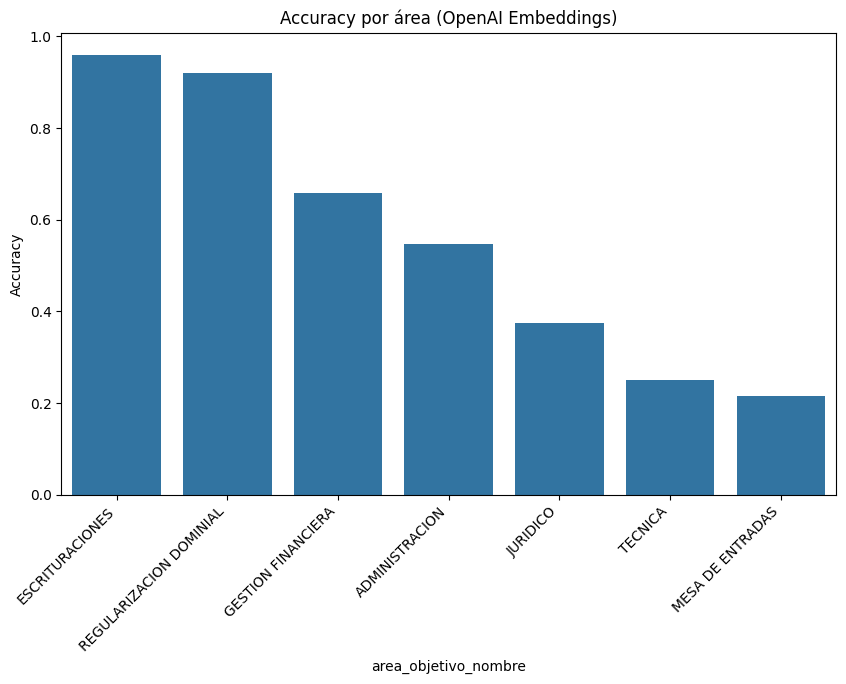


 MATRIZ DE CONFUSIÓN (crudo)



,ADMINISTRACION,ESCRITURACIONES,GESTION FINANCIERA,JURIDICO,MESA DE ENTRADAS,REGULARIZACION DOMINIAL,TECNICA
ADMINISTRACION,23,9,1,0,1,8,0
ESCRITURACIONES,0,72,1,0,0,1,1
GESTION FINANCIERA,13,4,100,0,0,35,0
JURIDICO,1,0,0,3,3,1,0
MESA DE ENTRADAS,1,11,0,0,11,27,1
REGULARIZACION DOMINIAL,4,5,7,0,1,194,0
TECNICA,0,0,0,0,0,3,1



 INTERPRETACIÓN BÁSICA:


• Filas = área real
• Columnas = predicción del modelo

• Si una fila tiene muchas predicciones en otra columna → confusión frecuente 
  (ej: Regularización → Administración significa que muchas cosas de RD
   se clasifican como Administración).

• Si la diagonal es alta → buen rendimiento general.


 PALABRAS FRECUENTES EN ERRORES (sin stopwords)

Top 50 palabras frecuentes en asuntos mal clasificados (sin stopwords):

vivienda: 28
cancelacion: 15
deuda: 12
direccion: 12
pago: 11
lote: 10
terreno: 10
ref: 7
casa: 7
pagar: 7
honorarios: 6
servicios: 6
escribania: 6
cuotas: 6
documentacion: 6
libre: 6
plan: 5
barrio: 5
cedulon: 5
consulta: 4
planes: 4
compra: 4
pronto: 4
despacho: 4
cambio: 4
factura: 4
quiero: 4
notificacion: 3
venta: 3
total: 3
titularidad: 3
escrituracion: 3
viviendas: 3
intervencion: 3
habitacional: 3
cancelar: 3
escriturar: 3
necesito: 3
maria: 2
sociales: 2
provinciales: 2
contrato: 2
marques: 2
sobremonte: 2
sentencia: 2
divorcio: 2
dec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# === 1. CARGA DE DATOS ===

# Ya tenés el df_exp en memoria (experimento con OpenAI Embeddings)
df = df_exp.copy()

y_true = df["area_objetivo_nombre"]
y_pred = df["area_pred_openai_top1"]

labels = sorted(df["area_objetivo_nombre"].unique())


# === 2. MÉTRICAS GENERALES ===

print("====================================")
print(" MÉTRICAS GENERALES - OpenAI Embeddings")
print("====================================\n")

print("Accuracy top-1:", accuracy_score(y_true, y_pred))
print("\nReporte de clasificación:\n")
print(classification_report(y_true, y_pred))


# === 3. MATRIZ DE CONFUSIÓN ===

print("\n====================================")
print(" MATRIZ DE CONFUSIÓN")
print("====================================\n")

cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.title("Matriz de confusión - OpenAI Embeddings")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# === MATRIZ NORMALIZADA ===

cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.title("Matriz de confusión normalizada (%) - OpenAI Embeddings")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


# === 4. ERRORES MÁS IMPORTANTES ===

df_errores = df[df["area_objetivo_nombre"] != df["area_pred_openai_top1"]]

print("\n====================================")
print(" TOP ERRORES (primeros 15)")
print("====================================\n")

pd.set_option('display.max_colwidth', None)
display(df_errores[["asunto", "area_objetivo_nombre", "area_pred_openai_top1"]].head(15))


# === 5. ANÁLISIS DE ACCURACY POR ÁREA ===

print("\n====================================")
print(" ACCURACY POR ÁREA")
print("====================================\n")

accuracy_por_area = (
    df.groupby("area_objetivo_nombre")
    .apply(lambda x: (x["area_pred_openai_top1"] == x["area_objetivo_nombre"]).mean())
    .sort_values(ascending=False)
)

display(accuracy_por_area)

plt.figure(figsize=(10,6))
sns.barplot(x=accuracy_por_area.index, y=accuracy_por_area.values)
plt.title("Accuracy por área (OpenAI Embeddings)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.show()


# === 6. ÁREAS QUE MÁS SE CONFUNDEN ENTRE SÍ ===

print("\n====================================")
print(" MATRIZ DE CONFUSIÓN (crudo)")
print("====================================\n")

df_conf = pd.DataFrame(cm, index=labels, columns=labels)
display(df_conf)


print("\n====================================")
print(" INTERPRETACIÓN BÁSICA:")
print("====================================\n")
print("""
• Filas = área real
• Columnas = predicción del modelo

• Si una fila tiene muchas predicciones en otra columna → confusión frecuente
  (ej: Regularización → Administración significa que muchas cosas de RD
   se clasifican como Administración).

• Si la diagonal es alta → buen rendimiento general.
""")


# === 7. ANÁLISIS LÉXICO DE ERRORES (SIN STOPWORDS) ===

print("\n====================================")
print(" PALABRAS FRECUENTES EN ERRORES (sin stopwords)")
print("====================================\n")

from collections import Counter
import re
import nltk

# Descargar stopwords si no lo hiciste antes
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords_es = set(stopwords.words('spanish'))

# Stopwords adicionales específicas de tu dominio
stopwords_custom = {
    "sr", "sra", "señor", "señora", "vecino", "vecina",
    "nota", "tramite", "trámite", "documento",
    "solicita", "solicito", "presenta", "presento",
    "pide", "adjunta", "adjunto", "solicitud",
    "expediente", "expte", "exp",
    "beneficiario", "beneficiaria", "de", "del"
}

stopwords_total = stopwords_es.union(stopwords_custom)

def limpiar(texto):
    if pd.isna(texto):
        return ""
    return re.sub(r"[^a-záéíóúñüA-ZÁÉÍÓÚÑÜ\s]", " ", texto.lower())

errores_textos = df_errores["asunto"].apply(limpiar).str.split()

counter = Counter()
for palabras in errores_textos:
    palabras_filtradas = [
        p for p in palabras
        if p not in stopwords_total and len(p) > 2
    ]
    counter.update(palabras_filtradas)

print("Top 50 palabras frecuentes en asuntos mal clasificados (sin stopwords):\n")
for palabra, freq in counter.most_common(50):
    print(f"{palabra}: {freq}")


# Guardar este experimento en Drive (como hicimos antes)

In [ ]:
import os
from datetime import datetime

def crear_carpeta_experimento(nombre_base="experimento"):
    # Fecha para versionado automático
    fecha = datetime.now().strftime("%Y%m%d_%H%M%S")
    carpeta = f"/content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/{nombre_base}_{fecha}/"
    os.makedirs(carpeta, exist_ok=True)
    return carpeta

In [ ]:
def guardar_resultados(carpeta_experimento, df_resultados):
    ruta = os.path.join(carpeta_experimento, "resultados.csv")
    df_resultados.to_csv(ruta, index=False, encoding="utf-8")
    print(f"✔ Resultados guardados en: {ruta}")

In [ ]:
import json

def guardar_metricas(
    carpeta_experimento,
    accuracy,
    classification_report_text,
    parametros_modelo,
    descripcion_experimento=""
):
    metricas = {
        "accuracy": accuracy,
        "classification_report": classification_report_text,
        "parametros_modelo": parametros_modelo,
        "descripcion": descripcion_experimento
    }

    ruta_json = os.path.join(carpeta_experimento, "metricas.json")
    with open(ruta_json, "w", encoding="utf-8") as f:
        json.dump(metricas, f, indent=4, ensure_ascii=False)

    print(f"✔ Métricas guardadas en: {ruta_json}")

In [ ]:
carpeta = crear_carpeta_experimento("experimento_openai_embeddings")

# Resultados completos
guardar_resultados(carpeta, df_exp)

# Métricas
clas_report_text = classification_report(y_true, y_pred)

parametros_modelo = {
    "tipo": "Clasificación por similitud de embeddings",
    "descripción":"OpenAI Embeddings -- similitud coseno",
    "modelo_embedding": EMBEDDING_MODEL,
    "estrategia": "cosine_similarity asunto vs descripción de área",
    "cantidad_asuntos": len(df_exp),
    "cantidad_areas": len(area_descripciones)
}

descripcion = """
Experimento usando OpenAI Embeddings (text-embedding-3-small).
Se generan embeddings para cada asunto y para la descripción de cada área.
Se clasifica por similitud coseno (top-1 y top-3).
"""

guardar_metricas(
    carpeta,
    accuracy_score(y_true, y_pred),
    clas_report_text,
    parametros_modelo,
    descripcion
)


✔ Resultados guardados en: /content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/experimento_openai_embeddings_20251128_023757/resultados.csv
✔ Métricas guardadas en: /content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/experimento_openai_embeddings_20251128_023757/metricas.json
